In [39]:
import sys
sys.path.append("../src/")

import datetime
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

from tdms_io import get_reader_array, get_data_from_array, get_dir_properties


In [72]:
from scipy.signal import ShortTimeFFT
from scipy.signal.windows import gaussian
from obspy.signal.filter import bandpass
from matplotlib.colors import LogNorm
from scipy.signal import butter, sosfilt

def ts_spectrogram(dir_path:str, prepro_para:dict, t_start:datetime):
    cha1, cha2, sps, freqmin, freqmax, n_minute = prepro_para.get('cha1'), prepro_para.get('cha2'), prepro_para.get('sps'), prepro_para.get('freqmin'), prepro_para.get('freqmax'), prepro_para.get('n_minute')
    reader_array, timestamps = get_reader_array(dir_path)

    mid_cha = int(0.5 * (cha1 + cha2))
    prepro_para.update({'cha1':mid_cha, 'cha2':mid_cha+1})
    
    data = get_data_from_array(reader_array, prepro_para, t_start, timestamps, duration=timedelta(minutes=n_minute))[:, 0]
    
    data = np.float32(bandpass(data,
                            0.9 * freqmin,
                            1.1 * freqmax,
                            df=sps,
                            corners=4,
                            zerophase=True))
    
    N = data.shape[0]
    g_std = 12
    gaussian_win = gaussian(100, g_std, sym=True)
    stft = ShortTimeFFT(gaussian_win, hop=50, fs=sps, scale_to='psd')
    spec = stft.spectrogram(data)

    fig1, ax1 = plt.subplots(figsize=(6., 4.))
    t_lo, t_hi = stft.extent(N)[:2]
    ax1.set_title(rf"{t_start} at channel {cha1}")
    ax1.set(xlabel=f"Time $t$ in seconds ({stft.p_num(N)} slices, " +
                rf"$\Delta t = {stft.delta_t:g}\,$s)",
            ylabel=f"Freq. $f$ in Hz ({stft.f_pts} bins, " +
                rf"$\Delta f = {stft.delta_f:g}\,$Hz)",
            xlim=(t_lo, t_hi))
    print(f'spec max: {spec.max()}; spec min: {spec.min()}')
    # spec = 10 * np.log10(np.fmax(spec, 1e-4))     # disabled for now, norm below is doing the same essentially
    ext = stft.extent(N)
    im1 = ax1.imshow(spec, origin='lower', aspect='auto', norm=LogNorm(vmin=1e-4), 
                     extent=ext, cmap='jet')
    if n_minute > 1440:
        _ = plt.xticks(np.linspace(0, ext[1], int(n_minute/1440)+1), pd.date_range(t_start, t_start+timedelta(minutes=n_minute), freq='D'), rotation=30)
        _ = plt.xticks(np.linspace(0, ext[1], int(n_minute/360)+1), minor=True)
    else: 
        _ = plt.xticks(np.linspace(0, ext[1], 4), pd.date_range(t_start, t_start+timedelta(minutes=n_minute), periods=4), rotation=30)
        _ = plt.xticks(np.linspace(0, ext[1], 16), minor=True)
    plt.ylim(freqmin, freqmax)
    fig1.colorbar(im1, label='Power Spectral Density ' + r"$20\,\log_{10}|S_x(t, f)|$ in dB")
    plt.tight_layout()
    plt.show(block=False)
    plt.close()


def butter_bandpass(lowcut, highcut, fs, order):
    """Butterworth Bandpass Filter Creator, returns a bandpass filter

    Keyword arguments:
        lowcut -- lower bound of the filter -1 for no lower bound  (lowpass)
        highcut -- higher bound of the filter -1 for no upper bound (highpass)
        fs -- frequency of recorded data
        order -- the order of the filter
    """

    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    if lowcut == -1:
        sos = butter(order, high, analog=False, btype='low', output='sos')
    elif highcut == -1:
        sos = butter(order, low, analog=False, btype='high', output='sos')
    else:
        sos = butter(order, [low, high], analog=False, btype='band', output='sos')
    return sos


def butter_bandpass_filter(data, fs, lowcut=-1, highcut=-1, order=6):
    """Applies a butterworth filter to a channel of data and returns the filtered data

    Keyword arguments:
        data -- single channel of data for filtering
        fs -- frequency of recording
        lowcut -- lower bound for filter defaults to -1 meaning no lower bound
        highcut -- higher bound for filter defaults to -1 meaning no higher bound
        order -- the order of the filter
    """
    sos = butter_bandpass(lowcut, highcut, fs, order)
    y = sosfilt(sos, data)
    return y

In [105]:
# dir_path = "/media/harry/Elements/DAS_Data/Myanmar_Quake/"
dir_path = "F:/Myanmar_Quake/"
reader_array, timestamps = get_reader_array(dir_path)
props = get_dir_properties(dir_path)
print(props['FileInfo'])
n_chs = reader_array[0].fileinfo['n_channels']
print(n_chs)
prepro_para = {
        'cha1': 0,
        'cha2': 1727,
        'sps': props.get('SamplingFrequency[Hz]'),
        'spatial_res': props.get('SpatialResolution[m]'),
        'spatial_ratio': 1,
        'n_minute': 1,
        'freqmax': 500,
        'freqmin': 0.001,
}

t0 = datetime.strptime("2025-03-28T06:48:40", "%Y-%m-%dT%H:%M:%S")
# p-wave at 06:49:02 ish
# s-wave at 07:18:16 ish

180 files available from 2025-03-28 06:30:25.948612 to 2025-03-28 07:59:55.948612

1728


In [106]:
data = get_data_from_array(reader_array, prepro_para, t0, timestamps, duration=timedelta(minutes=1))
print(data.shape)

(60000, 1728)


In [107]:
filt_data = butter_bandpass_filter(data, prepro_para.get('sps'), -1, 5)
print(data.shape)

(60000, 1728)


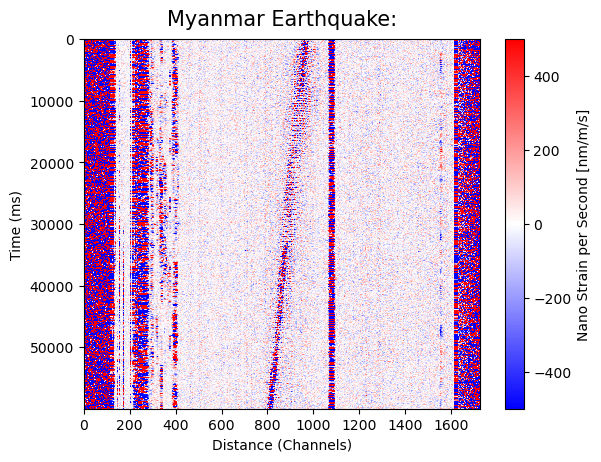

In [108]:
bounds = 500

fig, ax = plt.subplots()
img1 = ax.imshow(data, aspect='auto', interpolation='none', vmin=-bounds, vmax=bounds, cmap='bwr')
plt.ylabel('Time (ms)')
#ax.plot(depth[6000], 6250/fs, color='green', linewidth = 3, marker='o', markerfacecolor='green', markersize=5)
#plt.xlim(550, 650)
plt.xlabel('Distance (Channels)')
#plt.title(f"{props.get('GPSTimeStamp')} - Zoomed")
plt.title(f"Myanmar Earthquake:", fontsize = 15 , pad=10)
fig.colorbar(img1, label= "Nano Strain per Second [nm/m/s]")

plt.show(block=False)
plt.close()

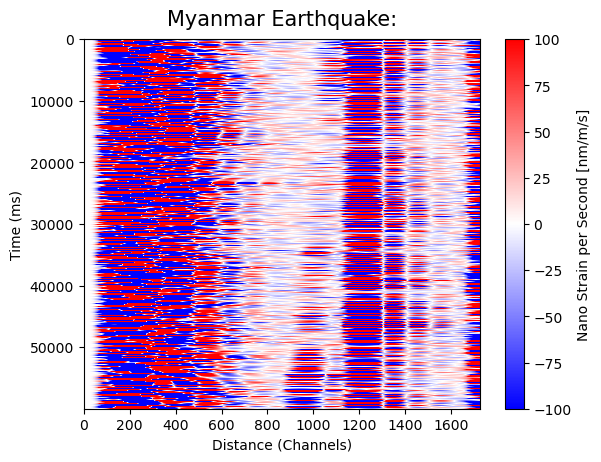

In [109]:
bounds = 100

fig, ax = plt.subplots()
img1 = ax.imshow(filt_data, aspect='auto', interpolation='none', vmin=-bounds, vmax=bounds, cmap='bwr')
plt.ylabel('Time (ms)')
#ax.plot(depth[6000], 6250/fs, color='green', linewidth = 3, marker='o', markerfacecolor='green', markersize=5)
#plt.xlim(550, 650)
plt.xlabel('Distance (Channels)')
#plt.title(f"{props.get('GPSTimeStamp')} - Zoomed")
plt.title(f"Myanmar Earthquake:", fontsize = 15 , pad=10)
fig.colorbar(img1, label= "Nano Strain per Second [nm/m/s]")

plt.show(block=False)
plt.close()

180 files available from 2025-03-28 06:30:25.948612 to 2025-03-28 07:59:55.948612
spec max: 104254.33080252558; spec min: 2.387476881922438e-20


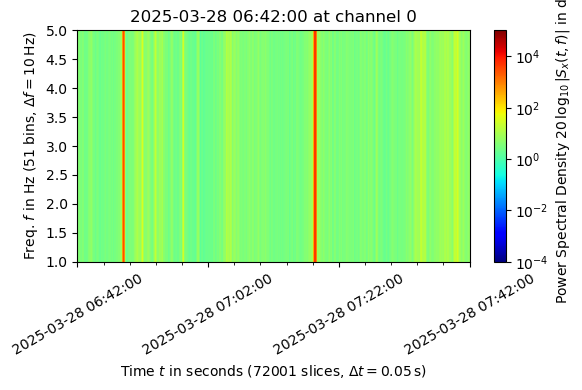

In [65]:
spec_prepro_para = prepro_para.copy()
spec_prepro_para.update({'freqmax':5.0, 
                         'n_minute': 60})

ts_spectrogram(dir_path, spec_prepro_para, t0)

180 files available from 2025-03-28 06:30:25.948612 to 2025-03-28 07:59:55.948612
spec max: 162977.65545769298; spec min: 9.017528959001701e-16


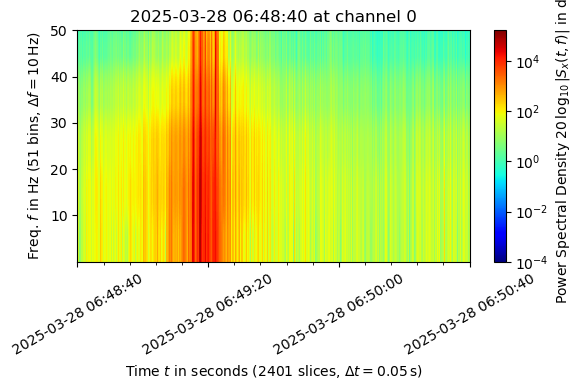

In [110]:
spec_prepro_para = prepro_para.copy()
spec_prepro_para.update({'freqmax':50.0, 
                         'n_minute': 2})

ts_spectrogram(dir_path, spec_prepro_para, t0)

# p-wave at 06:49:02 ish
# s-wave at 07:18:16 ish